# Detecting Retina Damage From Optical Coherence Tomography (OCT) Images, using Transfer Learning on VGG16 CNN Model

## Installing and Importing Libraries

In [297]:
import os, random, math
from glob import glob
import pandas as pd
import numpy as np
from numpy import expand_dims
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sn
from skimage.transform import resize
from skimage.color import gray2rgb
from sklearn.metrics import classification_report, confusion_matrix
from IPython.display import SVG
import keract
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import applications, optimizers
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.utils import to_categorical, model_to_dot, plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger, ReduceLROnPlateau

In [298]:
def flatten(liste):
    """Aplatit une liste de listes"""
    resultat = []
    for element in liste:
        if isinstance(element, list):
            resultat.extend(flatten(element))
        else:
            resultat.append(element)
    return resultat

## Importing Dataset and Data Pre-Processing

In [299]:
data_dir = "../data/OCT2017/"
train_data_dir= '../data/OCT2017/train/'
val_data_dir= '../data/OCT2017/val/'
test_data_dir= '../data/OCT2017/test/'

In [300]:
# Open a file
datasets = ['train', 'val', 'test']
global_length = 0
for dataset in datasets :
    path = data_dir+dataset+'/'
    dataset_length = 0
    for directory in os.listdir(path):
        for root, dirs, files in os.walk(path+directory):
            dataset_length += len(files)
    global_length += dataset_length
    print(f'{dataset} : {dataset_length}')
print('global :', global_length)

train : 83484
val : 32
test : 968
global : 84484


In [301]:
# on recherche la classe minoritaire
classes_counter = {'CNV': [], 'DME': [], 'DRUSEN': [], 'NORMAL': []}

for root, dirs, files in os.walk('../data/OCT2017/'):
    for file in files :
        for key, values in classes_counter.items():
            if file.split('-')[0] == key :
                classes_counter[key].append(root+'/'+file)

min_sample = min([len(x) for x in classes_counter.values()])
print(min_sample)


8866


In [302]:
train_size = math.floor(min_sample*0.7)
val_size = math.floor(min_sample*0.15)
test_size = math.floor(min_sample*0.15)
print(f'train : {train_size} \nvalidation : {val_size} \ntest : {test_size} \nglobal : {train_size+val_size+test_size}')

train : 6206 
validation : 1329 
test : 1329 
global : 8864


In [303]:
def create_datasets(size):

    dataset = []
    
    for value in classes_counter.values():
        random_files = random.sample(value, size)
        dataset.append(random_files)
        for file in random_files:
            value.remove(file)

    return flatten(dataset)

In [304]:
train_dataset = create_datasets(train_size)
val_dataset = create_datasets(val_size)
test_dataset = create_datasets(test_size)

In [305]:
print(f'train : {len(train_dataset)} \nvalidation : {len(val_dataset)} \ntest : {len(test_dataset)} \nglobal : {len(train_dataset)+len(val_dataset)+len(test_dataset)}')

train : 24824 
validation : 5316 
test : 5316 
global : 35456


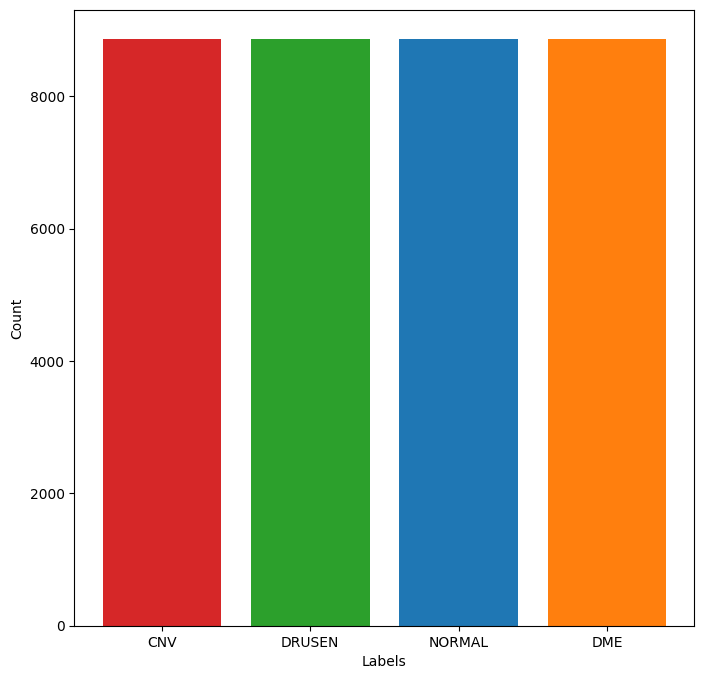

In [306]:
plt.rcParams['figure.figsize'] = (8.0, 8.0)
plt.bar(['CNV', 'DRUSEN','NORMAL', 'DME'], [min_sample, min_sample,min_sample,min_sample], color=['tab:red', 'tab:green', 'tab:blue', 'tab:orange'])
plt.axis('on')
plt.xlabel("Labels") 
plt.ylabel("Count") 
plt.savefig('img/undersampling_labels_vs_counts.png', transparent= False, bbox_inches= 'tight', dpi= 400)
plt.show() 

### Keras Data Generators

In [307]:
img_width, img_height = 150, 150 
batch_size = 32
channels = 3

In [308]:
# création d'un dataframe de chemin de fichiers du dataset d'entrainement
train_df = pd.DataFrame(train_dataset, columns=['filepath'])
train_df['class'] = train_df['filepath'].apply(lambda x: (x.split('/')[-1]).split('-')[0])

# instanciation de generateurs de données d'entrainement 
train_datagen = ImageDataGenerator(
    rescale= 1./255,
    zoom_range= (0.73, 0.9),
    horizontal_flip= True,
    rotation_range= 10,
    width_shift_range= 0.10,
    fill_mode= 'constant',
    height_shift_range= 0.10,   
    brightness_range= (0.55, 0.9),
)

# génération d'un jeu de données transformées pour l'entrainement
train_generator = train_datagen.flow_from_dataframe(  
    train_df,
    x_col='filepath',
    y_col='class',
    target_size= (img_width, img_height), 
    color_mode= 'rgb',
    batch_size= batch_size,  
    class_mode= 'categorical',
    shuffle= True, 
    seed= 1337
)

Found 24824 validated image filenames belonging to 4 classes.


In [309]:
# création d'un dataframe de chemin de fichiers du dataset d'entrainement
val_df = pd.DataFrame(val_dataset, columns=['filepath'])
val_df['class'] = val_df['filepath'].apply(lambda x: (x.split('/')[-1]).split('-')[0])

# instanciation de generateurs de données de validation 
valid_datagen = ImageDataGenerator(
    rescale= 1./255, 
)
valid_generator = valid_datagen.flow_from_dataframe(
    val_df,
    x_col='filepath',
    y_col='class',
    target_size= (img_width, img_height),
    color_mode= 'rgb',
    batch_size= batch_size,  
    class_mode= 'categorical',
    shuffle= True, 
    seed= 1337
)

Found 5316 validated image filenames belonging to 4 classes.


In [310]:
# création d'un dataframe de chemin de fichiers du dataset de test
test_df = pd.DataFrame(test_dataset, columns=['filepath'])
test_df['class'] = test_df['filepath'].apply(lambda x: (x.split('/')[-1]).split('-')[0])

# instanciation de generateurs de données de test 
test_datagen = ImageDataGenerator(
    rescale= 1./255, 
)
test_generator = test_datagen.flow_from_dataframe(  
    test_df,
    x_col='filepath',
    y_col='class',
    target_size= (img_width, img_height), 
    color_mode= 'rgb',
    batch_size= batch_size,        
    class_mode= 'categorical',
    shuffle= False, 
)

Found 5316 validated image filenames belonging to 4 classes.


In [311]:
# encodage des catégories
num_classes = len(train_generator.class_indices)  

train_labels = train_generator.classes 
train_labels = to_categorical(train_labels, num_classes=num_classes)

valid_labels = valid_generator.classes 
valid_labels = to_categorical(valid_labels, num_classes=num_classes)

In [312]:
nb_train_samples = len(train_generator.filenames)  
nb_valid_samples = len(valid_generator.filenames)
nb_test_samples = len(test_generator.filenames)

print('train set :', nb_train_samples,'\nvalidation set :', nb_valid_samples, '\ntest set :', nb_test_samples)

train set : 24824 
validation set : 5316 
test set : 5316


## Model

In [313]:
model_name = 'vgg16_e10b64_3'
# creation du dossier du modèle
if not os.path.exists(model_name):
   os.makedirs(model_name)

In [314]:
# instanciation d'un model VGG16 avec pré-entrainement imagenet
vgg16 = VGG16(include_top= False, input_shape=(img_width, img_height,channels), weights= 'imagenet')
vgg16.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [315]:
# creation du model avec transfert learning de vgg16 et ajout de couches de sortie
model = Sequential()

for layer in vgg16.layers:
    model.add(layer)

for layer in model.layers:
    layer.trainable= False

model.add(Flatten(input_shape=(4, 4, 512)))
model.add(Dropout(0.2))
model.add(Dense(4,activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 37, 37, 256)       2

In [316]:
model.compile(
    optimizer= keras.optimizers.Adam(learning_rate= 0.0001), 
    loss='categorical_crossentropy', 
    metrics= ['accuracy']
    )

In [317]:
# définition des hyperparamètres du model
numepochs = 10
batch_size = 64

In [318]:
checkpoint_filepath = model_name+'/tmp/checkpoint'
checkpoint = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)
earlystop = EarlyStopping(monitor='val_accuracy', patience=5, verbose=1)
callbacks_list = [earlystop,checkpoint]

In [319]:
history = model.fit(train_generator, 
                        epochs=numepochs, 
                        batch_size = batch_size,
                        validation_data=valid_generator, 
                        verbose=1,
                        callbacks = callbacks_list
                        )

Epoch 1/10
776/776 [==============================] - 2653s 3s/step - loss: 1.0150 - accuracy: 0.5843 - val_loss: 0.8475 - val_accuracy: 0.6898
Epoch 2/10
776/776 [==============================] - 2531s 3s/step - loss: 0.7753 - accuracy: 0.7111 - val_loss: 0.7620 - val_accuracy: 0.6996
Epoch 3/10
776/776 [==============================] - 2502s 3s/step - loss: 0.7059 - accuracy: 0.7357 - val_loss: 0.7023 - val_accuracy: 0.7325
Epoch 4/10
776/776 [==============================] - 2510s 3s/step - loss: 0.6618 - accuracy: 0.7507 - val_loss: 0.6872 - val_accuracy: 0.7323
Epoch 5/10
776/776 [==============================] - 2524s 3s/step - loss: 0.6439 - accuracy: 0.7565 - val_loss: 0.6621 - val_accuracy: 0.7464
Epoch 6/10
776/776 [==============================] - 2360s 3s/step - loss: 0.6198 - accuracy: 0.7672 - val_loss: 0.6382 - val_accuracy: 0.7541
Epoch 7/10
776/776 [==============================] - 2310s 3s/step - loss: 0.6057 - accuracy: 0.7720 - val_loss: 0.6276 - val_accuracy:

### Evaluations on Test Dataset

In [320]:
(eval_loss, eval_accuracy) = model.evaluate(test_generator, batch_size= batch_size, verbose= 1)
print('Test Loss: ', eval_loss)
print('Test Accuracy: ', eval_accuracy)

167/167 [==============================] - 423s 3s/step - loss: 0.6198 - accuracy: 0.7649
Test Loss:  0.6198495030403137
Test Accuracy:  0.7648608088493347


In [322]:
if not os.path.exists(model_name+'/img'):
   os.makedirs(model_name+'/img')

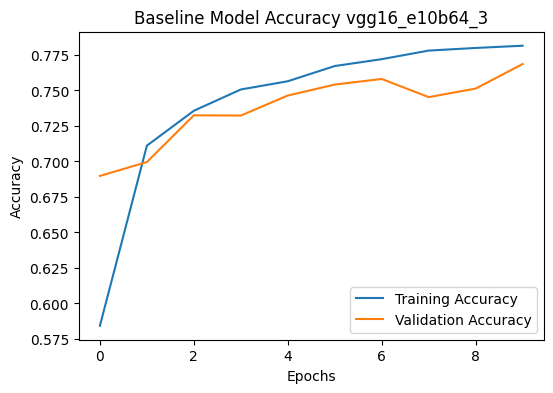

In [323]:
plt.subplot()
plt.rcParams['figure.figsize'] = (6.0, 4.0)
plt.title(f'Baseline Model Accuracy {model_name}')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Training Accuracy','Validation Accuracy'])
plt.savefig(model_name+'/img/baseline_acc_epoch_'+model_name+'.png', transparent= False, bbox_inches= 'tight', dpi= 400)
plt.show()

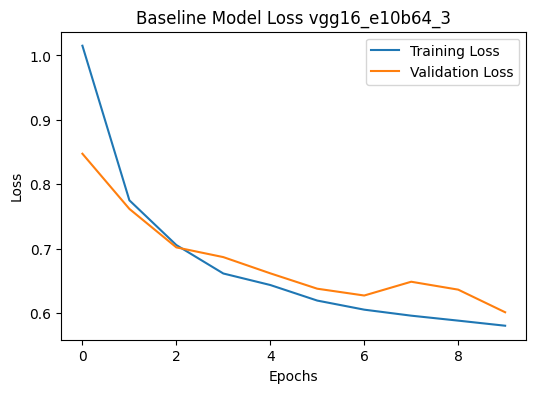

In [324]:
plt.subplot()
plt.title(f'Baseline Model Loss {model_name}')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Training Loss','Validation Loss'])
plt.savefig(model_name+'/img/baseline_loss_epoch_'+model_name+'.png', transparent= False, bbox_inches= 'tight', dpi= 400)
plt.show()

167/167 [==============================] - 419s 3s/step


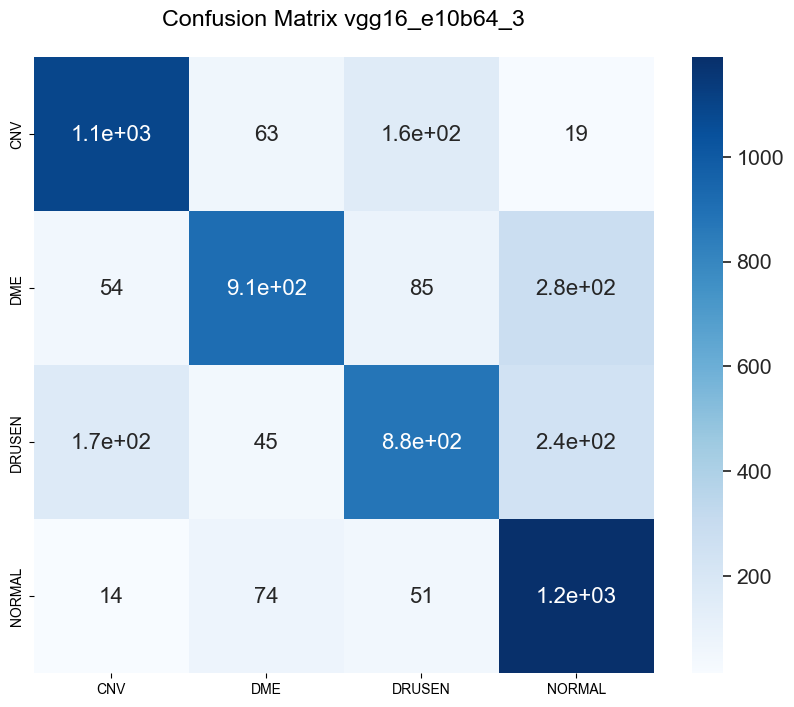

In [325]:
Y_pred = model.predict(test_generator, nb_test_samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
cm = confusion_matrix(test_generator.classes, y_pred)
df_cm = pd.DataFrame(cm, list(test_generator.class_indices.keys()), list(test_generator.class_indices.keys()))
fig, ax = plt.subplots(figsize=(10,8))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, cmap=plt.cm.Blues)
plt.title(f'Confusion Matrix {model_name}\n')
plt.savefig(model_name+'/img/confusion_matrix_'+model_name+'.png', transparent= False, bbox_inches= 'tight', dpi= 400)
plt.show()

In [326]:
print(f'Classification Report {model_name}\n')
target_names = list(test_generator.class_indices.keys())
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

Classification Report vgg16_e10b64_3

              precision    recall  f1-score   support

         CNV       0.82      0.82      0.82      1329
         DME       0.83      0.69      0.75      1329
      DRUSEN       0.75      0.66      0.70      1329
      NORMAL       0.69      0.90      0.78      1329

    accuracy                           0.76      5316
   macro avg       0.77      0.76      0.76      5316
weighted avg       0.77      0.76      0.76      5316



### Save the model

In [327]:
model_save_h5 = model_name+"/retinal_oct_model_"+model_name+".h5"
model_save_json = model_name+"/retinal_oct_model_"+model_name+".json"
model_save_weights = model_name+"/retinal_oct_model_"+model_name+"_weights.h5"
model_save_metrics = model_name+"/retinal_oct_model_"+model_name+"_eval.json"

In [328]:
# save model and architecture to h5 file
model.save(model_save_h5)
print("Saved h5 model to disk")

Saved h5 model to disk


In [329]:
#save the model architecture to JSON file
from keras.models import model_from_json
# serialize model to json
json_model = model.to_json()
with open(model_save_json, 'w') as json_file:
    json_file.write(json_model)
print("Saved json model to disk")

Saved json model to disk


In [330]:
#saving the weights of the model
model.save_weights(model_save_weights)
print("Saved model weights to disk")

Saved model weights to disk


In [331]:
import json
# save model metrics
json_model_eval = {}
json_model_eval["model_name"]=model_name
json_model_eval["loss"] = eval_loss
json_model_eval["accuracy"] = eval_accuracy
with open(model_save_metrics, 'w') as json_file:
    json_file.write(str(json_model_eval))
print("Saved model metrics to disk")

Saved model metrics to disk
